In [25]:
import torch
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
import numpy as np

from models.craft import CRAFT


model_path = '../Best_340_r0.773712_p0.847574_f10.808960.pth'
img_path = '../data/IC15/test/img/img_10.jpg'
label_path = '../data/IC15/test/gt/gt_img_10.txt'
device = 'cpu'
long_size = 1800

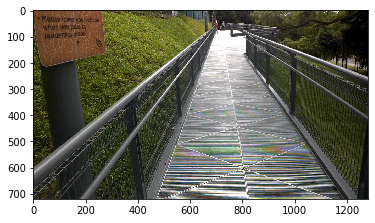

In [8]:
net = CRAFT(num_out=2, pretrained=False)
net = net.to(device)
state_dict = torch.load(model_path, map_location=device)['state_dict']
net.load_state_dict(state_dict)
net.eval()

In [36]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

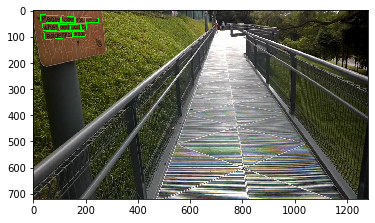

True

In [22]:
img_with_label = img
boxes = []
with open(label_path, encoding='utf-8', mode='r') as f:
    for line in f.readlines():
        box = []
        if ',' in line:
            params = line.strip().strip('\ufeff').strip('\xef\xbb\xbf').split(',')
        else:
            params = line.strip().strip('\ufeff').strip('\xef\xbb\xbf').split(' ')
       
        if not params[-1].isdigit():
            params.pop(-1)
        for i, val in enumerate(params):
            if i % 2 == 0:
                x = int(val)
            elif i % 2 == 1:
                y = int(val)
                box.append([x, y])
        boxes.append(box)

for poly in boxes:
    img_with_label=cv2.drawContours(img_with_label,np.array([poly]),-1,(0,255,0),2)
    
plt.imshow(img_with_label)
plt.show()

img_with_label = cv2.cvtColor(img_with_label, cv2.COLOR_RGB2BGR)
cv2.imwrite('../img_with_label.jpg', img_with_label)

In [37]:
h, w = img.shape[:2]
print(h)
print(w)

if long_size != None:
    scale = long_size / max(h, w)
    img = cv2.resize(img, None, fx=scale, fy=scale)
    
tensor = transforms.ToTensor()(img)
tensor = tensor.unsqueeze_(0)
tensor = tensor.to(device)

preds = net(tensor)

720 ,
1280


In [73]:
def center_filter(center, probs, threld):
    label_num, label_img = cv2.connectedComponents(center.astype(np.uint8), connectivity=4)

    label_values = []
    for label_idx in range(1, label_num):
        if np.sum(label_img == label_idx) < 10:
            label_img[label_img == label_idx] = 0
            continue

        score_i = np.mean(probs[label_img == label_idx]) 
        if score_i < threld:
            center[label_img==label_idx] = 0
    return center


preds2 = preds.squeeze(0)

bi_region = preds2[1, :, :]
dist_map = preds2[0, :, :]

bi_region = torch.sigmoid(bi_region)
if len(bi_region.shape) == 3:
    bi_region = bi_region.squeeze(0)

dist_map = torch.sigmoid(dist_map)

if len(dist_map.shape) == 3:
    dist_map = dist_map.squeeze(0)

#
dist_map = torch.add(dist_map, bi_region)
dist_map = torch.add(dist_map, -1)

ones_tensor = torch.ones_like(dist_map, dtype=torch.float32)
zeros_tensor = torch.zeros_like(dist_map, dtype=torch.float32)
region = torch.where(dist_map >= 0.295, ones_tensor, zeros_tensor)
center1 = torch.where(dist_map >= 0.6, ones_tensor, zeros_tensor)
center2 = torch.where(dist_map >= 0.7, ones_tensor, zeros_tensor)
center3 = torch.where(dist_map >= 0.8, ones_tensor, zeros_tensor)

region = region.to(device='cpu', non_blocking=True).detach().numpy()
center1 = center1.to(device='cpu', non_blocking=True).numpy()
center2 = center2.to(device='cpu', non_blocking=True).numpy()
center3 = center3.to(device='cpu', non_blocking=True).numpy()

bi_region = bi_region.to(device='cpu', non_blocking=True).detach().numpy()
dist_map = dist_map.to(device='cpu', non_blocking=True).detach().numpy()

dist_map = center_filter(dist_map, bi_region, 0.99)
center1 = center_filter(center1, bi_region, 0.99)
center2 = center_filter(center2, bi_region, 0.99)
center3 = center_filter(center3, bi_region, 0.99)

dist_map_draw = dist_map*255
dist_map_draw = cv2.cvtColor(dist_map_draw, cv2.COLOR_GRAY2BGR)
center1 = center1.astype(np.uint8)
center2 = center2.astype(np.uint8)
center3 = center3.astype(np.uint8)

_, contours, hierarchy = cv2.findContours(center1,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  
cv2.drawContours(dist_map_draw,contours,-1,(0,0,255),1)
_, contours, hierarchy = cv2.findContours(center2,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  
cv2.drawContours(dist_map_draw,contours,-1,(0,255,0),1)
_, contours, hierarchy = cv2.findContours(center3,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  
cv2.drawContours(dist_map_draw,contours,-1,(255,0,0),1)

print(dist_map_draw.shape)
dist_map_draw = cv2.resize(dist_map_draw, None, fx=1.0/scale, fy=1.0/scale)
print(dist_map_draw.shape)
cv2.imwrite('../img_10_res.jpg',dist_map_draw)

(1012, 1800, 3)
(720, 1280, 3)


True